<h1 align=center> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;应用系统体系架构 - 人工智能模块 </h1>

<h1 align=center> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A4：循环神经网络 - 作业</h1>

### 关于这个Notebook

在这个Notebook中，大家参照上课的上课给出的案例，构建循环神经网络来对比特币数据集进行预测。

该数据集在文件BCHAIN-MKPRU中，该数据集来自于美国大学生数学建模竞赛2022年的Problem C: Trading Strategies。题目中对数据集的描述如下：

BCHAIN-MKPRU.csv
- Date: The date in mm-dd-yyyy (month-day-year) format.
- Value: The price in U.S. dollars of a single bitcoin on the indicated date.

### 构建循环神经网络(Recurrent Neural Nets)
<font color=red>作业要求：</font>

- <font color=red>你可以使用Keras来构建和训练自己的循环神经网络RNN和LSTM，并通过调整超参数使你的模型的能够准确预测比特币的价格。</font>
- <font color=red>你应该通过参数优化来提升你的模型的准确性，使其预测误差尽量小。</font>

## 1. 加载必要的包

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## 2. 加载数据集

In [22]:
data = pd.read_csv("BCHAIN-MKPRU.csv")
data.describe()

,Value
count,1826.000000
mean,12206.068281
std,14043.891627
min,594.080000
25%,3994.982500
50%,7924.460000
75%,11084.730000
max,63554.440000


## 3. 数据预处理

In [23]:
'''
参照案例，对上述数据进行预处理，使其适合RNN模型进行训练，并对数据集进行切分，包含训练集和测试集
'''
# 选择 'Value' 列作为目标变量
dataset = data[['Value']].values.astype(float)

# 使用 MinMaxScaler 将数据缩放到 0 到 1 之间
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 将数据集拆分为训练集和测试集
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 创建数据集，将时间序列数据转换为监督学习问题
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# 设置 look_back 值，表示使用过去多少个时间步来预测下一个时间步
look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# 将输入数据 reshape 为 [samples, time steps, features] 的格式
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## 4. 构建 RNN 模型进行预测

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)             │ (None, 10, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)

Test Loss: 0.0015
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


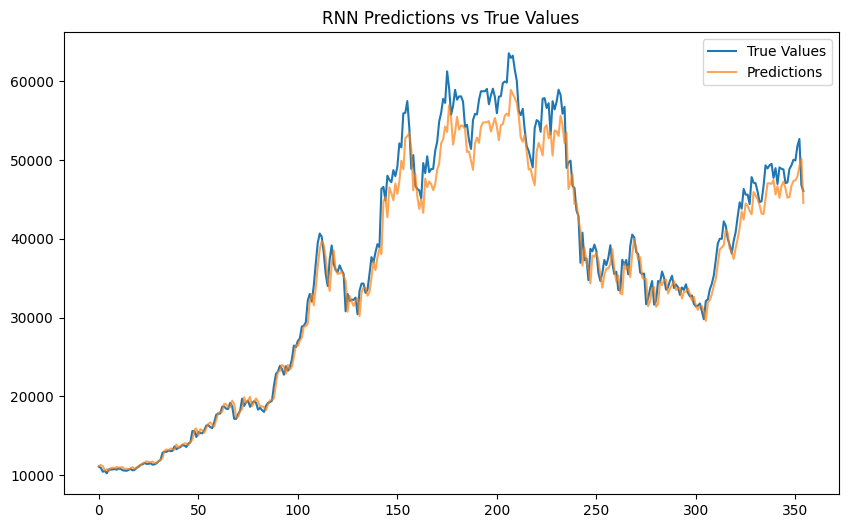

In [15]:
'''
编写你自己的RNN模型
'''
# 创建 RNN 模型
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(SimpleRNN(units=50))
model.add(Dense(1))

# 编译模型
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

'''
编译并训练你自己的RNN模型
'''
# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

model.save("model.keras")

'''
评估你的模型
'''
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predictions', alpha=0.7)
plt.legend()
plt.title("RNN Predictions vs True Values")
plt.show()

## 5. 构建 LSTM 模型进行预测

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Test Loss: 0.0024
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


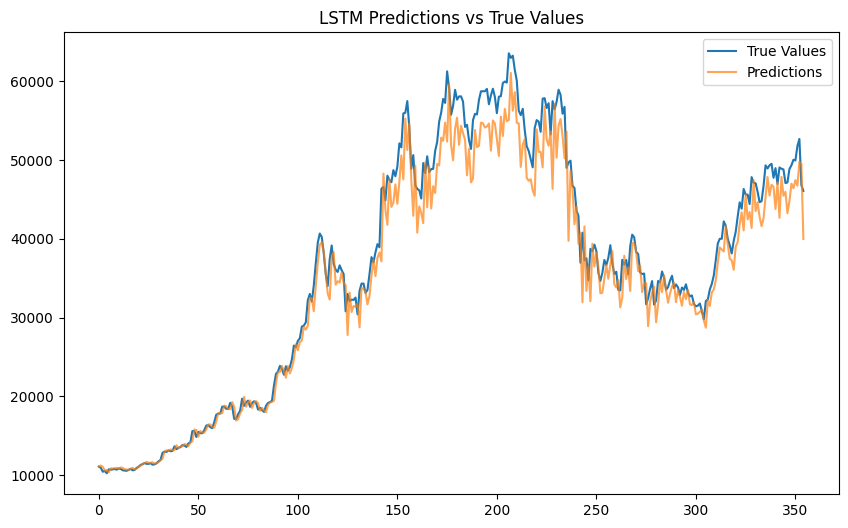

In [24]:
'''
编写你自己的LSTM模型
'''
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# 编译模型
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

'''
编译并训练你自己的LSTM模型
'''
# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

model.save("model.keras")

'''
评估你的模型
'''
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predictions', alpha=0.7)
plt.legend()
plt.title("LSTM Predictions vs True Values")
plt.show()